## Neural Networks: Homework 6

In [4]:
import numpy as np
from scipy import signal
import scipy.stats as st
from sklearn import cross_validation
from sklearn import preprocessing
import sklearn.linear_model as lm
import matplotlib.pyplot as plt
import scipy.io

from sklearn.cross_validation import KFold
#from sklearn.preprocessing import scale, normalize
%matplotlib inline

dig_train_data = scipy.io.loadmat('dataset/train.mat')

dig_test_data = scipy.io.loadmat('dataset/test.mat')
X = dig_train_data['train_images']
#print X.shape
X = X.T
for i in range(len(X)):
    row = X[i]
    X[i] = np.rot90(np.fliplr(row))
    
Y = dig_train_data['train_labels']

In [5]:
X = X.reshape((60000, 28 * 28)).astype(float)

#More preprocessing: normalize the columns of X using sklearn.precossing with l2 norm
X = preprocessing.normalize(X, norm='l2',axis=1)

#Let's shuffle our data and correspoding labels in the beginning.
shuff =  np.arange(60000)
np.random.shuffle(shuff) #we 
#Randomly build a shuffle array
#Index this into our training data and labels to randomize them
#They use the same random shuffled array so an image still corresponds to the correct label via a shared index
Y = Y[shuff]
X = X[shuff]

Y_new = 0.15 * np.ones((60000, 10)).astype(float)
#print Y_new
#print Y
for i in range(60000):
    ind = Y[i][0]
    #print ind
    #A = np.zeros((1,10)).astype(int)
    #A[0][ind] = 0.85
    Y_new[i][ind] = 0.85
#print Y.shape[0] 
Y = Y_new


#With this, we have expanded Y into a matrix of dimensions 60,000 by 10

X_plus_1 = np.column_stack((X, np.ones(60000)))

X_test = X_plus_1[:10000]
Y_test = Y[:10000]
#print X_test.shape
#print Y_test.shape
X_train = X_plus_1[10000:]
Y_train = Y[10000:]
#print X_train.shape
#print Y_train.shape

print X_train.shape

(50000, 785)


We need to transform Y where each y input is now a 10 by 1 vector of all 0s save a 1 where the i corresponds to the actual class label. The line of code below will append a column of 1s to the end of the matrix. So we now have 785 features.
Let's first set aside 10,000 data points and their corresponding labels for testing, to see how well our accuracy is before we try to submit to Kaggle.
Since we've already randomly shuffled our data/labels, we can just take the first 10,000 data points for our test data, while the last 50,000 will be for training.
We will have 785 units in the input layer. We will have 201 units in the hidden layer

In [18]:
class NeuralNet(object):
    
    def __init__(self, X_tr, Y_tr, N):
        self.inputLayers = 785 
        self.numHidden = 201 #two hundred and one hidden layers
        self.outputLayers = 10
        self.epsilon = 0.01
        self.numIters = 60000
        self.Xtr = X_tr
        self.Ytr = Y_tr
        if N < X_tr.shape[0]:
            self.batch_size = N #if N =1, this is just stochastic gradient descent
        else: 
            print "Set batch to 1"
            self.batch_size = 1
        
        self.V = 0.1 * np.random.randn(200, self.inputLayers) + 0
        self.W = 0.1 * np.random.randn(10, self.numHidden) + 0
        
    def stochastic_forward(self, x): 
        #x is a 1 x 785 data point array
        
        self.z2 = np.dot(self.V, x.T) #(200,1)
        #print self.z2.shape
        
        self.a2 = np.tanh(self.z2)
        
        #print self.a2.shape
        
        #Now we add a row of 1s to a2, which are the hidden layer bias weights
        #print self.a2.shape
        a = np.matrix(np.ones(self.a2.shape[1]))
        #print a.shape
        self.a2 = np.append(self.a2, a, axis=0)
        #print self.a2.shape
        
        self.z3 = np.dot(self.W, self.a2)
        
        yHat = self.sigmoid(self.z3)
        
        #yHat[yHat > 1.0] = 1.0
        #yHat[yHat <= 0.0] = 0.0000001
        
        return yHat 
    
    def matrix_forward_pass(self, X_train):#, Y_train):
        TT = np.tanh(np.dot(self.V, X_train.T))
        v = np.ones((TT.shape[1]))
        #print v.shape
        #print TT.shape
        h_1 = np.append(TT, [v], axis=0) #add row of 1s to TT
        
        siggy = (self.sigmoid(np.dot(self.W, h_1))).T

        Y_predicted = np.zeros(siggy.shape)

        for i in range(siggy.shape[0]):
            J = np.argmax(siggy[i])
            #print J
            Y_predicted[i][J] = 1
        return Y_predicted.astype(int)
    
    def mean_backprop(self, X, y):
        #self.yHat = self.stochastic_forward(X)
        
        delta3 = np.multiply(-(y - self.yHat), self.sigmoidPrime(self.z3))
        dJdW = np.dot(delta3, self.a2.T)
        
        #print delta3.shape
        #print self.W.T.shape
        D = self.tanh_deriv(self.z2)
        #print D.shape
        C = np.dot(self.W.T, delta3)[:200]
        delta2 = np.multiply(C, D)
        dJdV = np.dot(delta2, X)
        
        return dJdV, dJdW
        
        
    def trainNeuralNetwork_mean(self, X_train, Y_train):# learn_rate):
        #X is the images...i.e. the data set, which is 50,000 by (784 + 1)
        #Y is the self of corresponding labels of size 50,000 by 10
        iterations = 0
        #rand_index_array = 
        while iterations < self.numIters:
            #rand_index = np.random.random_integers(0, X_train.shape[0]-1) for stochastic gradient descent
            rand_index = np.random.choice(X_train.shape[0], self.batch_size, replace=False)
            rand_X_pt = np.matrix(X_train[rand_index])

            rand_Y_pt = np.matrix(Y_train[rand_index]).T
            
            self.yHat = self.stochastic_forward(rand_X_pt)          
            
            dLdV, dLdW = self.mean_backprop(rand_X_pt, rand_Y_pt)
            
            #stochastic update rule
            self.V = self.V + self.epsilon * dLdV
            self.W = self.W + self.epsilon * dLdW
            
            #Let's check our error rate calculations here
            if np.mod(iterations, 1000) == 0:
                self.trainerror(X_train, Y_train)
                self.error(self.Xtr, self.Ytr)
                print "Iteration Number: " + str(iterations)
                #self.calc_mean_error(rand_Y_pt)
                #self.epsilon /= 0.5
                print "\n"
            
            iterations += 1

        #return self.V, self.W
        return self.Y_test_labels
        
    
    def trainNeuralNetwork_crossetro(self, X_train, Y_train):# learn_rate):
        #X is the images...i.e. the data set, which is 50,000 by (784 + 1)
        #Y is the self of corresponding labels of size 50,000 by 10
        iterations = 0
        while iterations < self.numIters:
            #rand_index = np.random.random_integers(0, X_train.shape[0]-1)
            rand_index = np.random.choice(X_train.shape[0], self.batch_size, replace=False)

            rand_X_pt = np.matrix(X_train[rand_index])

            rand_Y_pt = np.matrix(Y_train[rand_index]).T
            
            self.yHat = self.stochastic_forward(rand_X_pt)          
            
            dLdV, dLdW = self.cross_entro_backprop(rand_X_pt, rand_Y_pt)
            
            #stochastic update rule
            self.V = self.V + self.epsilon * dLdV
            self.W = self.W + self.epsilon * dLdW
            
            if np.mod(iterations, 1000) == 0:
                self.trainerror(X_train, Y_train)
                self.error(self.Xtr, self.Ytr)
                print "Iteration Number: " + str(iterations)
                #self.calc_mean_error(rand_Y_pt)
                #self.epsilon /= 0.5
                print "\n"
            
            iterations += 1

        #return self.V, self.W
        return self.Y_test_labels
    
    def cross_entro_backprop(self, x, y):
        
        delta3 = np.multiply(-2.0 * np.multiply(y, self.yHat) - y + self.yHat, self.sigmoidPrime(self.z3))
        dJdW = np.dot(delta3, self.a2.T)
        #print dJdW.shape
        
        #print delta3.shape
        #print self.W.T.shape
        D = self.tanh_deriv(self.z2)
        #print D.shape
        C = np.dot(self.W.T, delta3)
        #print C
        C = C[:200]
        #print C
        delta2 = np.multiply(C, D)
        dJdV = np.dot(delta2, x)
        #print dJdV, dJdW
        return dJdV, dJdW

    def sigmoid(self, z):
        #we 
        
        return 1.0/(1.0 + np.exp(z))
    
    def tanh_deriv(self, z):
        return 1.0 - np.multiply(np.tanh(z), np.tanh(z))
    
    def sigmoidPrime(self, z):
        return np.exp(-z)/(1.0 + np.multiply(np.exp(-z), np.exp(-z)))
    
    def error(self, X_test, Y_test):
        err = 0.0
        #print np.argmax(Y_test_labels[0])
        self.Y_test_labels = self.matrix_forward_pass(X_test)#, Y_test)
        #print self.Y_test_labels.shape
        for i in range(X_test.shape[0]):
            pred_max = np.argmax(self.Y_test_labels[i])
            true_max = np.argmax(Y_test[i])
            #print pred_max, true_max
            if true_max != pred_max:
                err += 1.0
        err = err / X_test.shape[0]
        print "Classification Accuracy: " + str(1.0 - err)
        a = np.multiply(self.Y_test_labels - Y_test, self.Y_test_labels - Y_test)
        #print a.shape #prints (10,10)
        #print a
        print "Training Error: " + str(a.sum())
        #print self.W.item(0)
        
    def trainerror(self, X_train, Y_train):
        err = 0.0
        self.Y_train_labels = self.matrix_forward_pass(X_train)
        for i in range(X_train.shape[0]):
            pred_max = np.argmax(self.Y_train_labels[i])
            true_max = np.argmax(Y_train[i])
            if true_max != pred_max:
                err += 1.0
        err = err / X_train.shape[0]
        print "Training Accuracy: " + str(1.0 - err)
        
        

In [12]:
NN = NeuralNet(X_test, Y_test, 1)
Y_test_Labels = NN.trainNeuralNetwork_mean(X_train, Y_train)

In [13]:
NN_cross = NeuralNet(X_test, Y_test, 1)
NN_cross.trainNeuralNetwork_crossetro(X_train, Y_train)

array([[0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1]])

In [14]:
X_kaggle = dig_test_data['test_images']
#print X_kaggle.shape
#plt.imshow(X_kaggle[4])
#This is a lovely eight too

In [15]:
X_kaggle = X_kaggle.reshape((X_kaggle.shape[0], 28 * 28)).astype(float)
X_kaggle = preprocessing.normalize(X_kaggle, norm='l2',axis=1)
X_kaggle = np.column_stack((X_kaggle, np.ones(10000)))
Y_labels = NN.matrix_forward_pass(X_kaggle)

In [84]:
digit_kaggle = open("BestKaggle.csv", "w+")
digit_kaggle.write("Id,Category\n")
class_array = np.argmax(Y_labels, axis = 1)
for i in range(class_array.size):
    digit_kaggle.write(str(i+1) + "," + str(class_array[i]) + "\n")
digit_kaggle.close()

## Problem 2: Data and Graphs

For the initialization parts, I decided to start with a learning rate of 0.01, going through 100k iterations (basically twice as much as the number of training data points as a decent training metric). 
I initialized the V and W training weight matrices using the piece of code:

        self.V = 0.1 * np.random.randn(200, self.inputLayers) + 0
        self.W = 0.1 * np.random.randn(10, self.numHidden) + 0
        
where self.inputLayers = 785 and self.numHidden = 201


Testing our data on a neural network that implemented mean loss with a minbatch size of 250 gave a Kaggle score of: 

    0.96940.
    
So only 306 were predicted wrong.

Running on the network that prediected the kaggle test set I received the error values:
    0.8921
    0.1112
    0.0851
    0.0668
    0.0632
    0.0539
    0.052
    0.0519
    0.0468
    0.0436
    0.0466
    0.0429
    0.0399
    0.0424
    0.0411
    0.0386
    0.0378
    0.0388
    0.038
    0.0383

Running on mean with batch size of 1 took 9 minutes and 55 seconds.
Running on cross with batch size of 1 took 9 minutes and 27 seconds.

Looking at the two loss functions running the same batch size and number of iterations, it seems that the cross-entropy loss function produced a lower error rate on the validation set that the mean loss function.

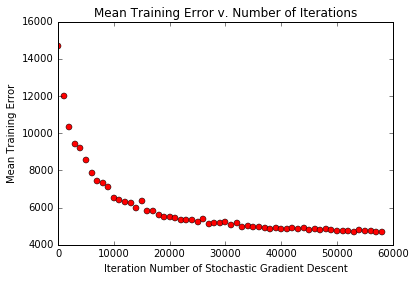

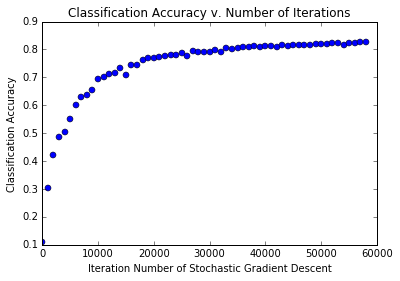

In [44]:
train_acc_array = [0.10946, 0.29886, 0.42472, 0.48704, 0.50698, 0.55828, 0.60032, 0.6331, 0.6373, 0.65708, 0.6976,
                  0.70458, 0.71454, 0.719, 0.73874, 0.74788, 0.74932, 0.76306,
                  0.76304, 0.77168, 0.77112, 0.77282, 0.77888, 0.78332, 0.78212, 0.7907, 0.77882, 0.79704, 0.79162,
                  0.79346, 0.79248, 0.80198, 0.79544, 0.8048, 0.80384,
                  0.80896, 0.8074, 0.81004, 0.81362, 0.81098, 0.81586, 0.8165, 0.80962, 0.81714, 0.81194, 
                  0.81818, 0.81616, 0.8153, 0.81594, 0.81912, 0.82324, 0.82248, 0.82238, 0.82622, 
                  0.81928, 0.82452, 0.82238, 0.8295, 0.8304]

class_acc_array = [0.1099, 0.3021, 0.4219, 0.4873, 0.5048, 0.5511, 0.6002, 0.6284, 0.6364, 0.6532, 0.6947,
                  0.7019, 0.7105, 0.7156, 0.7337, 0.7082, 0.7462, 0.7458, 0.7611, 0.77, 0.7682, 0.7719,
                  0.778, 0.7813, 0.7803, 0.7891, 0.7776, 0.7953, 0.7916, 0.7916, 0.7893, 0.7997, 0.7927,
                  0.8054, 0.8023, 0.8055, 0.8073, 0.8091, 0.8129, 0.809, 0.8142, 0.8135, 0.8098, 0.8149, 0.8121,
                   0.8168, 0.8149, 0.8167, 0.8144, 0.8193, 0.8209, 0.8212, 0.8225, 0.8249, 0.8174,
                  0.8231, 0.8216, 0.8253, 0.8265]

training_error_array = [14711.4, 12020.6, 10343.4, 9427.8, 9182.8, 8534.6, 7847.2, 7452.4, 7340.4, 7105.2, 6524.2,
                       6423.4, 6303.0, 6231.6, 5978.2, 6335.2, 5803.2, 5808.8, 5594.6, 5470.0, 5495.2, 5443.4,
                       5358.0, 5311.8, 5325.8, 5202.6, 5363.6, 5115.8, 5167.6, 5167.6, 5199.8, 5054.2, 5152.2,
                       4974.4, 5017.8, 4973.0, 4947.8, 4922.6, 4869.4, 4924.0, 4851.2, 4861.0, 4912.8, 4841.4, 4880.6,
                       4814.8, 4841.4, 4816.2, 4848.4, 4779.8, 4757.4, 4753.2, 4735.0, 4701.4, 4806.4,
                       4726.6, 4747.6, 4695.8, 4679.0]

iter_number = np.arange(0, 59000, 1000)

train_acc_array = np.asarray(train_acc_array)
class_acc_array = np.asarray(class_acc_array)
training_error_array = np.asarray(training_error_array)

plt.plot(iter_number, training_error_array, 'ro')
plt.xlabel("Iteration Number of Stochastic Gradient Descent")
plt.ylabel("Mean Training Error")
plt.title("Mean Training Error v. Number of Iterations")
plt.show()
plt.plot(iter_number, class_acc_array, 'bo')
plt.xlabel("Iteration Number of Stochastic Gradient Descent")
plt.ylabel("Classification Accuracy")
plt.title("Classification Accuracy v. Number of Iterations")

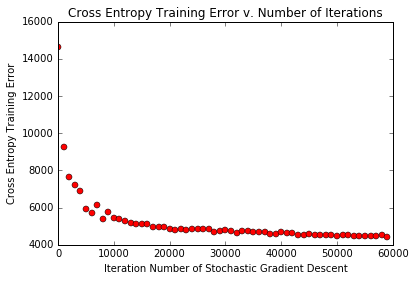

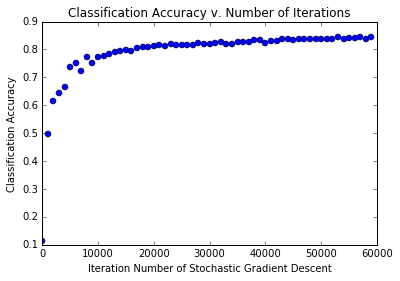

In [45]:
iter_cross = np.arange(0, 60000, 1000)

train_acc_cross = [0.1164,0.49862,0.6159,0.64378,0.665,0.7399, 0.74962,0.72266,0.77328
                    ,0.75214,0.76972,0.79216,0.7765,0.78576,0.79494,0.7962,0.797,0.80888
                    ,0.80986,0.81246,0.81222,0.81724,0.81104,0.81972,0.81734,0.8168,0.81518,0.81654,0.82662,0.81888
                    ,0.81954,0.82478,0.82872,0.82186,0.82076,0.8265,0.8304,0.82786,0.83582,0.83582
                    ,0.83108,0.83438,0.83444,0.84092,0.83668,0.84014,0.8411
                    ,0.84076,0.83988,0.8442,0.84382,0.83984,0.84506,0.84294,0.84062,0.8458,0.84568,0.84058,0.8464]

class_acc_cross = [0.1151,0.4977,0.6161,0.6447,0.6668,0.7389,0.7526,0.7236,0.7741,0.7507,0.7724,
                  0.776,0.7825,0.7923,0.7959,0.7967,0.7935,0.8064,0.8084,0.8079,0.8134,0.8171,0.8126,
                  0.8187,0.8149,0.8144,0.8148,0.8144,0.8243,0.8204,0.8183,0.8228,0.8283,0.821,0.8215,0.8268,
                  0.8277,0.8261, 0.8339,0.8347,0.8244,0.8306,0.8309,0.8361,0.8378,0.833,0.837,0.8389,
                  0.8372,0.8379,0.8394,0.8385,0.8362,0.8431,0.8393,0.8404,0.8429,0.8431,0.8368,0.8436]


train_error_cross = [14638.6,9282.2,7624.6,7224.2,6914.8,5905.4,5713.6,6119.6,5412.6,5740.2,5436.4,5386.0,
                     5295.0,5157.8,5107.4,5096.2,5141.0,4960.4,4932.4,4939.4,4862.4,4810.6,4873.6,4788.2,
                     4841.4,4848.4,4842.8,4848.4,4709.8,4764.4,4793.8,4730.8,4653.8,4756.0,4749.0,4674.8,
                     4662.2,4684.6,4575.4,4564.2,4708.4,4621.6,4617.4,4544.6,4520.8,4588.0,4532.0,4505.4,
                     4529.2,4519.4,4498.4,4511.0,4543.2,4446.6,4499.8,4484.4,4449.4,4446.6,4534.8,4439.6]

train_x = np.asarray(train_acc_cross)
class_x = np.asarray(class_acc_cross)
train_err_x = np.asarray(train_error_cross)

plt.plot(iter_cross, train_err_x, 'ro')
plt.xlabel("Iteration Number of Stochastic Gradient Descent")
plt.ylabel("Cross Entropy Training Error")
plt.title("Cross Entropy Training Error v. Number of Iterations")
plt.show()
plt.plot(iter_cross, class_x, 'bo')
plt.xlabel("Iteration Number of Stochastic Gradient Descent")
plt.ylabel("Classification Accuracy")
plt.title("Classification Accuracy v. Number of Iterations")

It seems that both loss functions have very similar accuracies as the iterations tend towards infinity, though the cross entropy does perform a bit better. Also, the cross entropy makes noticeably better predictions at lower iterations, given by the steepness of the curve for the number of iterations less than 10,000.